# IGM - MUEI
## Practice 3: JPEG
---
In this practice we will learn how JPEG coding works. 
* We will use a Python implementation available [here](https://github.com/ghallak/jpeg-python) 
* The implementation consists of a couple of script for encoding and decoding JPEG images, an implementation of Huffman entropy coding, and some utilities such as quantization matrices and list flattener.

### **Rules for the realization of the practice**
- The practice is done individually.
- Deadline (non-extendable): 20 December 2019.
- Delivery is made via the corresponding task in Moodle.
- The practice grade is evaluated on 10 points and represents 50% of the grade for this part of the subject.
- It is very important that each practice is original. The anti-plagiarism tool turnitin available at the UDC will be used.
- **Remember to document everything so that it is easy to follow the modifications in the code**.
- **Remember also to save the intermediate versions when required. Everything should run on the Jupiter Notebook.**


In [74]:
#@title encoder.py
%%writefile encoder.py

import argparse
import os
import math
import numpy as np
from utils import *
from scipy import fftpack
from PIL import Image
from huffman import HuffmanTree


def quantize(block, component):
    q = load_quantization_table(component)
    return (block / q).round().astype(np.int32)


def block_to_zigzag(block):
    return np.array([block[point] for point in zigzag_points(*block.shape)])


def dct_2d(image):
    return fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')


def run_length_encode(arr):
    # determine where the sequence is ending prematurely
    last_nonzero = -1
    for i, elem in enumerate(arr):
        if elem != 0:
            last_nonzero = i

    # each symbol is a (RUNLENGTH, SIZE) tuple
    symbols = []

    # values are binary representations of array elements using SIZE bits
    values = []

    run_length = 0

    for i, elem in enumerate(arr):
        if i > last_nonzero:
            symbols.append((0, 0))
            values.append(int_to_binstr(0))
            break
        elif elem == 0 and run_length < 15:
            run_length += 1
        else:
            size = bits_required(elem)
            symbols.append((run_length, size))
            values.append(int_to_binstr(elem))
            run_length = 0
    return symbols, values


def write_to_file(filepath, dc, ac, blocks_count, tables):
    try:
        f = open(filepath, 'w')
    except FileNotFoundError as e:
        raise FileNotFoundError(
                "No such directory: {}".format(
                    os.path.dirname(filepath))) from e

    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:

        # 16 bits for 'table_size'
        f.write(uint_to_binstr(len(tables[table_name]), 16))

        for key, value in tables[table_name].items():
            if table_name in {'dc_y', 'dc_c'}:
                # 4 bits for the 'category'
                # 4 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key, 4))
                f.write(uint_to_binstr(len(value), 4))
                f.write(value)
            else:
                # 4 bits for 'run_length'
                # 4 bits for 'size'
                # 8 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key[0], 4))
                f.write(uint_to_binstr(key[1], 4))
                f.write(uint_to_binstr(len(value), 8))
                f.write(value)

    # 32 bits for 'blocks_count'
    f.write(uint_to_binstr(blocks_count, 32))

    for b in range(blocks_count):
        for c in range(3):
            category = bits_required(dc[b, c])
            symbols, values = run_length_encode(ac[b, :, c])

            dc_table = tables['dc_y'] if c == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if c == 0 else tables['ac_c']

            f.write(dc_table[category])
            f.write(int_to_binstr(dc[b, c]))

            for i in range(len(symbols)):
                f.write(ac_table[tuple(symbols[i])])
                f.write(values[i])
    f.close()


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("input", help="path to the input image")
    parser.add_argument("output", help="path to the output image")
    args = parser.parse_args()

    input_file = args.input
    output_file = args.output

    image = Image.open(input_file)
    ycbcr = image.convert('YCbCr')

    npmat = np.array(ycbcr, dtype=np.uint8)

    rows, cols = npmat.shape[0], npmat.shape[1]

    # block size: 8x8
    if rows % 8 == cols % 8 == 0:
        blocks_count = rows // 8 * cols // 8
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of 8"))

    # dc is the top-left cell of the block, ac are all the other cells
    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            try:
                block_index += 1
            except NameError:
                block_index = 0

            for k in range(3):
                # split 8x8 block and center the data range on zero
                # [0, 255] --> [-128, 127]
                block = npmat[i:i+8, j:j+8, k] - 128

                dct_matrix = dct_2d(block)
                quant_matrix = quantize(dct_matrix,
                                        'lum' if k == 0 else 'chrom')
                zz = block_to_zigzag(quant_matrix)

                dc[block_index, k] = zz[0]
                ac[block_index, :, k] = zz[1:]

    H_DC_Y = HuffmanTree(np.vectorize(bits_required)(dc[:, 0]))
    H_DC_C = HuffmanTree(np.vectorize(bits_required)(dc[:, 1:].flat))
    H_AC_Y = HuffmanTree(
            flatten(run_length_encode(ac[i, :, 0])[0]
                    for i in range(blocks_count)))
    H_AC_C = HuffmanTree(
            flatten(run_length_encode(ac[i, :, j])[0]
                    for i in range(blocks_count) for j in [1, 2]))

    tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
              'ac_y': H_AC_Y.value_to_bitstring_table(),
              'dc_c': H_DC_C.value_to_bitstring_table(),
              'ac_c': H_AC_C.value_to_bitstring_table()}

    write_to_file(output_file, dc, ac, blocks_count, tables)


if __name__ == "__main__":
    main()



Overwriting encoder.py


In [75]:
#@title decoder.py
%%writefile decoder.py
import argparse
import math
import numpy as np
from utils import *
from scipy import fftpack
from PIL import Image


class JPEGFileReader:
    TABLE_SIZE_BITS = 16
    BLOCKS_COUNT_BITS = 32

    DC_CODE_LENGTH_BITS = 4
    CATEGORY_BITS = 4

    AC_CODE_LENGTH_BITS = 8
    RUN_LENGTH_BITS = 4
    SIZE_BITS = 4

    def __init__(self, filepath):
        self.__file = open(filepath, 'r')

    def read_int(self, size):
        if size == 0:
            return 0

        # the most significant bit indicates the sign of the number
        bin_num = self.__read_str(size)
        if bin_num[0] == '1':
            return self.__int2(bin_num)
        else:
            return self.__int2(binstr_flip(bin_num)) * -1

    def read_dc_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            category = self.__read_uint(self.CATEGORY_BITS)
            code_length = self.__read_uint(self.DC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = category
        return table

    def read_ac_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            run_length = self.__read_uint(self.RUN_LENGTH_BITS)
            size = self.__read_uint(self.SIZE_BITS)
            code_length = self.__read_uint(self.AC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = (run_length, size)
        return table

    def read_blocks_count(self):
        return self.__read_uint(self.BLOCKS_COUNT_BITS)

    def read_huffman_code(self, table):
        prefix = ''
        # TODO: break the loop if __read_char is not returing new char
        while prefix not in table:
            prefix += self.__read_char()
        return table[prefix]

    def __read_uint(self, size):
        if size <= 0:
            raise ValueError("size of unsigned int should be greater than 0")
        return self.__int2(self.__read_str(size))

    def __read_str(self, length):
        return self.__file.read(length)

    def __read_char(self):
        return self.__read_str(1)

    def __int2(self, bin_num):
        return int(bin_num, 2)


def read_image_file(filepath):
    reader = JPEGFileReader(filepath)

    tables = dict()
    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:
        if 'dc' in table_name:
            tables[table_name] = reader.read_dc_table()
        else:
            tables[table_name] = reader.read_ac_table()

    blocks_count = reader.read_blocks_count()

    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for block_index in range(blocks_count):
        for component in range(3):
            dc_table = tables['dc_y'] if component == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if component == 0 else tables['ac_c']

            category = reader.read_huffman_code(dc_table)
            dc[block_index, component] = reader.read_int(category)

            cells_count = 0

            # TODO: try to make reading AC coefficients better
            while cells_count < 63:
                run_length, size = reader.read_huffman_code(ac_table)

                if (run_length, size) == (0, 0):
                    while cells_count < 63:
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                else:
                    for i in range(run_length):
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                    if size == 0:
                        ac[block_index, cells_count, component] = 0
                    else:
                        value = reader.read_int(size)
                        ac[block_index, cells_count, component] = value
                    cells_count += 1

    return dc, ac, tables, blocks_count


def zigzag_to_block(zigzag):
    # assuming that the width and the height of the block are equal
    rows = cols = int(math.sqrt(len(zigzag)))

    if rows * cols != len(zigzag):
        raise ValueError("length of zigzag should be a perfect square")

    block = np.empty((rows, cols), np.int32)

    for i, point in enumerate(zigzag_points(rows, cols)):
        block[point] = zigzag[i]

    return block


def dequantize(block, component):
    q = load_quantization_table(component)
    return block * q


def idct_2d(image):
    return fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("input", help="path to the input image")
    args = parser.parse_args()

    dc, ac, tables, blocks_count = read_image_file(args.input)

    # assuming that the block is a 8x8 square
    block_side = 8

    # assuming that the image height and width are equal
    image_side = int(math.sqrt(blocks_count)) * block_side

    blocks_per_line = image_side // block_side

    npmat = np.empty((image_side, image_side, 3), dtype=np.uint8)

    for block_index in range(blocks_count):
        i = block_index // blocks_per_line * block_side
        j = block_index % blocks_per_line * block_side

        for c in range(3):
            zigzag = [dc[block_index, c]] + list(ac[block_index, :, c])
            quant_matrix = zigzag_to_block(zigzag)
            dct_matrix = dequantize(quant_matrix, 'lum' if c == 0 else 'chrom')
            block = idct_2d(dct_matrix)
            npmat[i:i+8, j:j+8, c] = block + 128

    image = Image.fromarray(npmat, 'YCbCr')
    image = image.convert('RGB')
    image.show()


if __name__ == "__main__":
    main()




Overwriting decoder.py


In [76]:
#@title huffman.py
%%writefile huffman.py
from queue import PriorityQueue


class HuffmanTree:

    class __Node:
        def __init__(self, value, freq, left_child, right_child):
            self.value = value
            self.freq = freq
            self.left_child = left_child
            self.right_child = right_child

        @classmethod
        def init_leaf(self, value, freq):
            return self(value, freq, None, None)

        @classmethod
        def init_node(self, left_child, right_child):
            freq = left_child.freq + right_child.freq
            return self(None, freq, left_child, right_child)

        def is_leaf(self):
            return self.value is not None

        def __eq__(self, other):
            stup = self.value, self.freq, self.left_child, self.right_child
            otup = other.value, other.freq, other.left_child, other.right_child
            return stup == otup

        def __nq__(self, other):
            return not (self == other)

        def __lt__(self, other):
            return self.freq < other.freq

        def __le__(self, other):
            return self.freq < other.freq or self.freq == other.freq

        def __gt__(self, other):
            return not (self <= other)

        def __ge__(self, other):
            return not (self < other)

    def __init__(self, arr):
        q = PriorityQueue()

        # calculate frequencies and insert them into a priority queue
        for val, freq in self.__calc_freq(arr).items():
            q.put(self.__Node.init_leaf(val, freq))

        while q.qsize() >= 2:
            u = q.get()
            v = q.get()

            q.put(self.__Node.init_node(u, v))

        self.__root = q.get()

        # dictionaries to store huffman table
        self.__value_to_bitstring = dict()

    def value_to_bitstring_table(self):
        if len(self.__value_to_bitstring.keys()) == 0:
            self.__create_huffman_table()
        return self.__value_to_bitstring

    def __create_huffman_table(self):
        def tree_traverse(current_node, bitstring=''):
            if current_node is None:
                return
            if current_node.is_leaf():
                self.__value_to_bitstring[current_node.value] = bitstring
                return
            tree_traverse(current_node.left_child, bitstring + '0')
            tree_traverse(current_node.right_child, bitstring + '1')

        tree_traverse(self.__root)

    def __calc_freq(self, arr):
        freq_dict = dict()
        for elem in arr:
            if elem in freq_dict:
                freq_dict[elem] += 1
            else:
                freq_dict[elem] = 1
        return freq_dict



Overwriting huffman.py


In [77]:
#@title utils.py
%%writefile utils.py
import numpy as np


def load_quantization_table(component):
    # Quantization Table for: Photoshop - (Save For Web 080)
    # (http://www.impulseadventure.com/photo/jpeg-quantization.html)
    if component == 'lum':
        q = np.array([[2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 4, 5, 7, 9],
                      [2, 2, 2, 4, 5, 7, 9, 12],
                      [3, 3, 4, 5, 8, 10, 12, 12],
                      [4, 4, 5, 7, 10, 12, 12, 12],
                      [5, 5, 7, 9, 12, 12, 12, 12],
                      [6, 6, 9, 12, 12, 12, 12, 12]])
    elif component == 'chrom':
        q = np.array([[3, 3, 5, 9, 13, 15, 15, 15],
                      [3, 4, 6, 11, 14, 12, 12, 12],
                      [5, 6, 9, 14, 12, 12, 12, 12],
                      [9, 11, 14, 12, 12, 12, 12, 12],
                      [13, 14, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12]])
    else:
        raise ValueError((
            "component should be either 'lum' or 'chrom', "
            "but '{comp}' was found").format(comp=component))

    return q


def zigzag_points(rows, cols):
    # constants for directions
    UP, DOWN, RIGHT, LEFT, UP_RIGHT, DOWN_LEFT = range(6)

    # move the point in different directions
    def move(direction, point):
        return {
            UP: lambda point: (point[0] - 1, point[1]),
            DOWN: lambda point: (point[0] + 1, point[1]),
            LEFT: lambda point: (point[0], point[1] - 1),
            RIGHT: lambda point: (point[0], point[1] + 1),
            UP_RIGHT: lambda point: move(UP, move(RIGHT, point)),
            DOWN_LEFT: lambda point: move(DOWN, move(LEFT, point))
        }[direction](point)

    # return true if point is inside the block bounds
    def inbounds(point):
        return 0 <= point[0] < rows and 0 <= point[1] < cols

    # start in the top-left cell
    point = (0, 0)

    # True when moving up-right, False when moving down-left
    move_up = True

    for i in range(rows * cols):
        yield point
        if move_up:
            if inbounds(move(UP_RIGHT, point)):
                point = move(UP_RIGHT, point)
            else:
                move_up = False
                if inbounds(move(RIGHT, point)):
                    point = move(RIGHT, point)
                else:
                    point = move(DOWN, point)
        else:
            if inbounds(move(DOWN_LEFT, point)):
                point = move(DOWN_LEFT, point)
            else:
                move_up = True
                if inbounds(move(DOWN, point)):
                    point = move(DOWN, point)
                else:
                    point = move(RIGHT, point)


def bits_required(n):
    n = abs(n)
    result = 0
    while n > 0:
        n >>= 1
        result += 1
    return result


def binstr_flip(binstr):
    # check if binstr is a binary string
    if not set(binstr).issubset('01'):
        raise ValueError("binstr should have only '0's and '1's")
    return ''.join(map(lambda c: '0' if c == '1' else '1', binstr))


def uint_to_binstr(number, size):
    return bin(number)[2:][-size:].zfill(size)


def int_to_binstr(n):
    if n == 0:
        return ''

    binstr = bin(abs(n))[2:]

    # change every 0 to 1 and vice verse when n is negative
    return binstr if n > 0 else binstr_flip(binstr)


def flatten(lst):
    return [item for sublist in lst for item in sublist]





Overwriting utils.py


### Exercise 1

* Download the Python source code for the JPEG implementation available in [https://github.com/ghallak/jpeg-python](https://github.com/ghallak/jpeg-python) and execute it from the Jypter Notebook (call the functions).
* Analyze the code. Notice that the code was not designed to be run on a Notebook. Determine the structure and arguments of `encoder.py` and `decoder.py` scripts.
* The encoder can be executed in Jupyter Notebook directly using:
```
!python encoder.py cameraman.png cameraman.jpegenc
```
where cameraman.png is the source image and cameraman.jpegenc is the resulting encoded bitstream. **Notice that the output bitstream is not formatted according to any JPEG container, hence it is not recognized as a JPEG file at all!**

* The decoder, however, does not write the result to a valid file format.


1.   Writing a JPEG image at the end of the `main()` function in `decoder.py` to be next plotted in the Jupyter Notebook is not a suitable solution. Explain why.
2.   Modify `decoder.py` to write the decoded JPEG image as a PNG file to be compared with the original one.
3.   Write the necessary code in the cell below to download a grayscale image, next run the encoder followed by the decoder, and finally plot both the original and the reconstructed JPEG images. 
4.   Compute both the PNSR and the SSIM.






Writing a JPEG image at the end of the main() function in decoder.py to be next plotted in the Jupyter Notebook is not a suitable solution because the image received from the 'encoder.py' module is already encoded as jpeg and this will cause the image to be encoded/compressed twice.

Image.save(filename) saves an image under the given filename. If no format is specified, the format to use is determined from the filename extension, if possible. 


Keyword options can be used to provide additional instructions to the writer:
compress_level

* compress_level

  ZLIB compression level, a number between 0 and 9: 1 gives best speed, 9 gives best compression, 0 gives no compression at all. Default is 6. When optimize option is True compress_level has no effect (it is set to 9 regardless of a value passed).


* optimize

  If present and true, instructs the PNG writer to make the output file as small as possible. This includes extra processing in order to find optimal encoder settings.
---------------------------

In [78]:
#@title decoder_pngoutput.py
%%writefile decoder_pngoutput.py
import argparse
import math
import numpy as np
from utils import *
from scipy import fftpack
from PIL import Image


class JPEGFileReader:
    TABLE_SIZE_BITS = 16
    BLOCKS_COUNT_BITS = 32

    DC_CODE_LENGTH_BITS = 4
    CATEGORY_BITS = 4

    AC_CODE_LENGTH_BITS = 8
    RUN_LENGTH_BITS = 4
    SIZE_BITS = 4

    def __init__(self, filepath):
        self.__file = open(filepath, 'r')

    def read_int(self, size):
        if size == 0:
            return 0

        # the most significant bit indicates the sign of the number
        bin_num = self.__read_str(size)
        if bin_num[0] == '1':
            return self.__int2(bin_num)
        else:
            return self.__int2(binstr_flip(bin_num)) * -1

    def read_dc_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            category = self.__read_uint(self.CATEGORY_BITS)
            code_length = self.__read_uint(self.DC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = category
        return table

    def read_ac_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            run_length = self.__read_uint(self.RUN_LENGTH_BITS)
            size = self.__read_uint(self.SIZE_BITS)
            code_length = self.__read_uint(self.AC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = (run_length, size)
        return table

    def read_blocks_count(self):
        return self.__read_uint(self.BLOCKS_COUNT_BITS)

    def read_huffman_code(self, table):
        prefix = ''
        # TODO: break the loop if __read_char is not returing new char
        while prefix not in table:
            prefix += self.__read_char()
        return table[prefix]

    def __read_uint(self, size):
        if size <= 0:
            raise ValueError("size of unsigned int should be greater than 0")
        return self.__int2(self.__read_str(size))

    def __read_str(self, length):
        return self.__file.read(length)

    def __read_char(self):
        return self.__read_str(1)

    def __int2(self, bin_num):
        return int(bin_num, 2)


def read_image_file(filepath):
    reader = JPEGFileReader(filepath)

    tables = dict()
    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:
        if 'dc' in table_name:
            tables[table_name] = reader.read_dc_table()
        else:
            tables[table_name] = reader.read_ac_table()

    blocks_count = reader.read_blocks_count()

    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for block_index in range(blocks_count):
        for component in range(3):
            dc_table = tables['dc_y'] if component == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if component == 0 else tables['ac_c']

            category = reader.read_huffman_code(dc_table)
            dc[block_index, component] = reader.read_int(category)

            cells_count = 0

            # TODO: try to make reading AC coefficients better
            while cells_count < 63:
                run_length, size = reader.read_huffman_code(ac_table)

                if (run_length, size) == (0, 0):
                    while cells_count < 63:
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                else:
                    for i in range(run_length):
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                    if size == 0:
                        ac[block_index, cells_count, component] = 0
                    else:
                        value = reader.read_int(size)
                        ac[block_index, cells_count, component] = value
                    cells_count += 1

    return dc, ac, tables, blocks_count


def zigzag_to_block(zigzag):
    # assuming that the width and the height of the block are equal
    rows = cols = int(math.sqrt(len(zigzag)))

    if rows * cols != len(zigzag):
        raise ValueError("length of zigzag should be a perfect square")

    block = np.empty((rows, cols), np.int32)

    for i, point in enumerate(zigzag_points(rows, cols)):
        block[point] = zigzag[i]

    return block


def dequantize(block, component):
    q = load_quantization_table(component)
    return block * q


def idct_2d(image):
    return fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("input", help="path to the input image")
    parser.add_argument("output", help="path to the output image")
    args = parser.parse_args()

    dc, ac, tables, blocks_count = read_image_file(args.input)
    output_file = args.output

    # assuming that the block is a 8x8 square
    block_side = 8

    # assuming that the image height and width are equal
    image_side = int(math.sqrt(blocks_count)) * block_side

    blocks_per_line = image_side // block_side

    npmat = np.empty((image_side, image_side, 3), dtype=np.uint8)

    for block_index in range(blocks_count):
        i = block_index // blocks_per_line * block_side
        j = block_index % blocks_per_line * block_side

        for c in range(3):
            zigzag = [dc[block_index, c]] + list(ac[block_index, :, c])
            quant_matrix = zigzag_to_block(zigzag)
            dct_matrix = dequantize(quant_matrix, 'lum' if c == 0 else 'chrom')
            block = idct_2d(dct_matrix)
            npmat[i:i+8, j:j+8, c] = block + 128

    image = Image.fromarray(npmat, 'YCbCr')
    image = image.convert('RGB')
    image.save(output_file+'.png', optimize=True, compress_level = 0)


if __name__ == "__main__":
    main()

Overwriting decoder_pngoutput.py


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


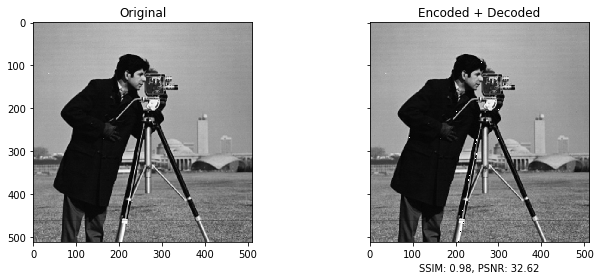

In [79]:
# Write your code here
import requests
from io import BytesIO
import os.path
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

# URL and separated filename
filename = r'cameraman.png'
url = 'https://www.researchgate.net/profile/Paul_Rodriguez16/publication/265988128/figure/fig1/AS:459614656438273@1486592081799/Input-test-images-a-Cameraman-grayscale-b-grayscale-Lena-and-c-color-Lena-All.png'
# Downloads the file to a local file if the file does not exist
if not os.path.exists(filename):
  print('Beginning file download...')
  buffer = requests.get(url, allow_redirects=True);
  open(filename, 'wb').write(buffer.content);

# Encodes the file if the encoded file does not exist
if not os.path.exists('cameraman.jpegenc'):
  !python encoder.py 'cameraman.png' 'cameraman.jpegenc'

# Decodes the file if the decoded file does not exist
if not os.path.exists('cameraman_output.png'):
  !python decoder_pngoutput.py 'cameraman.jpegenc' 'cameraman_output'


img1 = cv.imread(filename, cv.IMREAD_COLOR)
img2 = cv.imread('cameraman_output.png', cv.IMREAD_COLOR)
img_original = img_as_float(img1)
img_transformed = img_as_float(img2)

psnr_metric = psnr(img_original, img_transformed, data_range=img_transformed.max() - img_transformed.min())
ssim_metric = ssim(img_original, img_transformed, data_range=img_transformed.max() - img_transformed.min(), multichannel=True)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True, sharey=True)
ax = axes.ravel()
label = 'SSIM: %.2f, PSNR: %.2f'

ax[0].imshow(img_original)
ax[0].set_title('Original')

ax[1].imshow(img_transformed)
ax[1].set_xlabel(label % (ssim_metric, psnr_metric))
ax[1].set_title('Encoded + Decoded')

plt.tight_layout()
plt.show()


### Exercise 2
* Modify `encoder.py` and `decoder.py` scripts to convert them to functions easily callable from the Jupyter Notebook. 
* Repeat the code in Exercise 1 but now calling those functions directly.

In [80]:
#@title encoderscript.py
%%writefile encoderscript.py
import argparse
import os
import math
import numpy as np
from utils import *
from scipy import fftpack
from PIL import Image
from huffman import HuffmanTree


def quantize(block, component):
    q = load_quantization_table(component)
    return (block / q).round().astype(np.int32)


def block_to_zigzag(block):
    return np.array([block[point] for point in zigzag_points(*block.shape)])


def dct_2d(image):
    return fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')


def run_length_encode(arr):
    # determine where the sequence is ending prematurely
    last_nonzero = -1
    for i, elem in enumerate(arr):
        if elem != 0:
            last_nonzero = i

    # each symbol is a (RUNLENGTH, SIZE) tuple
    symbols = []

    # values are binary representations of array elements using SIZE bits
    values = []

    run_length = 0

    for i, elem in enumerate(arr):
        if i > last_nonzero:
            symbols.append((0, 0))
            values.append(int_to_binstr(0))
            break
        elif elem == 0 and run_length < 15:
            run_length += 1
        else:
            size = bits_required(elem)
            symbols.append((run_length, size))
            values.append(int_to_binstr(elem))
            run_length = 0
    return symbols, values


def write_to_file(filepath, dc, ac, blocks_count, tables):
    try:
        f = open(filepath, 'w')
    except FileNotFoundError as e:
        raise FileNotFoundError(
                "No such directory: {}".format(
                    os.path.dirname(filepath))) from e

    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:

        # 16 bits for 'table_size'
        f.write(uint_to_binstr(len(tables[table_name]), 16))

        for key, value in tables[table_name].items():
            if table_name in {'dc_y', 'dc_c'}:
                # 4 bits for the 'category'
                # 4 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key, 4))
                f.write(uint_to_binstr(len(value), 4))
                f.write(value)
            else:
                # 4 bits for 'run_length'
                # 4 bits for 'size'
                # 8 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key[0], 4))
                f.write(uint_to_binstr(key[1], 4))
                f.write(uint_to_binstr(len(value), 8))
                f.write(value)

    # 32 bits for 'blocks_count'
    f.write(uint_to_binstr(blocks_count, 32))

    for b in range(blocks_count):
        for c in range(3):
            category = bits_required(dc[b, c])
            symbols, values = run_length_encode(ac[b, :, c])

            dc_table = tables['dc_y'] if c == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if c == 0 else tables['ac_c']

            f.write(dc_table[category])
            f.write(int_to_binstr(dc[b, c]))

            for i in range(len(symbols)):
                f.write(ac_table[tuple(symbols[i])])
                f.write(values[i])
    f.close()


def encode(input, output):
    input_file = input
    output_file = output

    image = Image.open(input_file)
    ycbcr = image.convert('YCbCr')

    npmat = np.array(ycbcr, dtype=np.uint8)

    rows, cols = npmat.shape[0], npmat.shape[1]

    # block size: 8x8
    if rows % 8 == cols % 8 == 0:
        blocks_count = rows // 8 * cols // 8
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of 8"))

    # dc is the top-left cell of the block, ac are all the other cells
    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            try:
                block_index += 1
            except NameError:
                block_index = 0

            for k in range(3):
                # split 8x8 block and center the data range on zero
                # [0, 255] --> [-128, 127]
                block = npmat[i:i+8, j:j+8, k] - 128

                dct_matrix = dct_2d(block)
                quant_matrix = quantize(dct_matrix,
                                        'lum' if k == 0 else 'chrom')
                zz = block_to_zigzag(quant_matrix)

                dc[block_index, k] = zz[0]
                ac[block_index, :, k] = zz[1:]

    H_DC_Y = HuffmanTree(np.vectorize(bits_required)(dc[:, 0]))
    H_DC_C = HuffmanTree(np.vectorize(bits_required)(dc[:, 1:].flat))
    H_AC_Y = HuffmanTree(
            flatten(run_length_encode(ac[i, :, 0])[0]
                    for i in range(blocks_count)))
    H_AC_C = HuffmanTree(
            flatten(run_length_encode(ac[i, :, j])[0]
                    for i in range(blocks_count) for j in [1, 2]))

    tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
              'ac_y': H_AC_Y.value_to_bitstring_table(),
              'dc_c': H_DC_C.value_to_bitstring_table(),
              'ac_c': H_AC_C.value_to_bitstring_table()}

    write_to_file(output_file, dc, ac, blocks_count, tables)

Overwriting encoderscript.py


In [81]:
#@title decoderscript.py
%%writefile decoderscript.py
import argparse
import math
import numpy as np
from utils import *
from scipy import fftpack
from PIL import Image


class JPEGFileReader:
    TABLE_SIZE_BITS = 16
    BLOCKS_COUNT_BITS = 32

    DC_CODE_LENGTH_BITS = 4
    CATEGORY_BITS = 4

    AC_CODE_LENGTH_BITS = 8
    RUN_LENGTH_BITS = 4
    SIZE_BITS = 4

    def __init__(self, filepath):
        self.__file = open(filepath, 'r')

    def read_int(self, size):
        if size == 0:
            return 0

        # the most significant bit indicates the sign of the number
        bin_num = self.__read_str(size)
        if bin_num[0] == '1':
            return self.__int2(bin_num)
        else:
            return self.__int2(binstr_flip(bin_num)) * -1

    def read_dc_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            category = self.__read_uint(self.CATEGORY_BITS)
            code_length = self.__read_uint(self.DC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = category
        return table

    def read_ac_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            run_length = self.__read_uint(self.RUN_LENGTH_BITS)
            size = self.__read_uint(self.SIZE_BITS)
            code_length = self.__read_uint(self.AC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = (run_length, size)
        return table

    def read_blocks_count(self):
        return self.__read_uint(self.BLOCKS_COUNT_BITS)

    def read_huffman_code(self, table):
        prefix = ''
        # TODO: break the loop if __read_char is not returing new char
        while prefix not in table:
            prefix += self.__read_char()
        return table[prefix]

    def __read_uint(self, size):
        if size <= 0:
            raise ValueError("size of unsigned int should be greater than 0")
        return self.__int2(self.__read_str(size))

    def __read_str(self, length):
        return self.__file.read(length)

    def __read_char(self):
        return self.__read_str(1)

    def __int2(self, bin_num):
        return int(bin_num, 2)


def read_image_file(filepath):
    reader = JPEGFileReader(filepath)

    tables = dict()
    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:
        if 'dc' in table_name:
            tables[table_name] = reader.read_dc_table()
        else:
            tables[table_name] = reader.read_ac_table()

    blocks_count = reader.read_blocks_count()

    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for block_index in range(blocks_count):
        for component in range(3):
            dc_table = tables['dc_y'] if component == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if component == 0 else tables['ac_c']

            category = reader.read_huffman_code(dc_table)
            dc[block_index, component] = reader.read_int(category)

            cells_count = 0

            # TODO: try to make reading AC coefficients better
            while cells_count < 63:
                run_length, size = reader.read_huffman_code(ac_table)

                if (run_length, size) == (0, 0):
                    while cells_count < 63:
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                else:
                    for i in range(run_length):
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                    if size == 0:
                        ac[block_index, cells_count, component] = 0
                    else:
                        value = reader.read_int(size)
                        ac[block_index, cells_count, component] = value
                    cells_count += 1

    return dc, ac, tables, blocks_count


def zigzag_to_block(zigzag):
    # assuming that the width and the height of the block are equal
    rows = cols = int(math.sqrt(len(zigzag)))

    if rows * cols != len(zigzag):
        raise ValueError("length of zigzag should be a perfect square")

    block = np.empty((rows, cols), np.int32)

    for i, point in enumerate(zigzag_points(rows, cols)):
        block[point] = zigzag[i]

    return block


def dequantize(block, component):
    q = load_quantization_table(component)
    return block * q


def idct_2d(image):
    return fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')


def decode(input, output):
    dc, ac, tables, blocks_count = read_image_file(input)
    output_file = output

    # assuming that the block is a 8x8 square
    block_side = 8

    # assuming that the image height and width are equal
    image_side = int(math.sqrt(blocks_count)) * block_side

    blocks_per_line = image_side // block_side

    npmat = np.empty((image_side, image_side, 3), dtype=np.uint8)

    for block_index in range(blocks_count):
        i = block_index // blocks_per_line * block_side
        j = block_index % blocks_per_line * block_side

        for c in range(3):
            zigzag = [dc[block_index, c]] + list(ac[block_index, :, c])
            quant_matrix = zigzag_to_block(zigzag)
            dct_matrix = dequantize(quant_matrix, 'lum' if c == 0 else 'chrom')
            block = idct_2d(dct_matrix)
            npmat[i:i+8, j:j+8, c] = block + 128

    image = Image.fromarray(npmat, 'YCbCr')
    image = image.convert('RGB')
    image.save(output_file+'.png', optimize=True, compress_level = 0)

Overwriting decoderscript.py


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


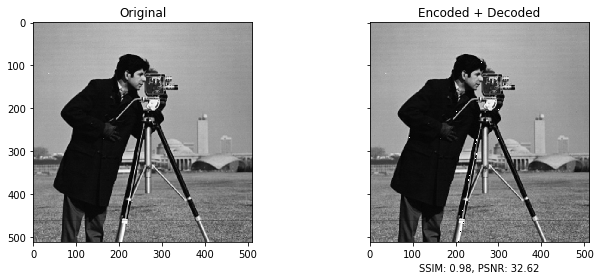

In [82]:
# Write your code here
import decoderscript
import encoderscript
import requests
from io import BytesIO
import os.path
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

# URL and separated filename
filename = r'cameraman.png'
url = 'https://www.researchgate.net/profile/Paul_Rodriguez16/publication/265988128/figure/fig1/AS:459614656438273@1486592081799/Input-test-images-a-Cameraman-grayscale-b-grayscale-Lena-and-c-color-Lena-All.png'
# Downloads the file to a local file if the file does not exist
if not os.path.exists(filename):
  print('Beginning file download...')
  buffer = requests.get(url, allow_redirects=True);
  open(filename, 'wb').write(buffer.content);

# Encodes the file if the encoded file does not exist
if not os.path.exists('cameraman.jpegenc'):
  encoder.encode('cameraman.png', 'cameraman.jpegenc')

# Decodes the file if the decoded file does not exist
if not os.path.exists('cameraman_output.png'):
  decoder.decode('cameraman.jpegenc', 'cameraman_output')


img1 = cv.imread(filename, cv.IMREAD_COLOR)
img2 = cv.imread('cameraman_output.png', cv.IMREAD_COLOR)
img_original = img_as_float(img1)
img_transformed = img_as_float(img2)
rows, cols, channels = img1.shape

psnr_metric = psnr(img_original, img_transformed, data_range=img_transformed.max() - img_transformed.min())
ssim_metric = ssim(img_original, img_transformed, data_range=img_transformed.max() - img_transformed.min(), multichannel=True)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharex=True, sharey=True)
ax = axes.ravel()
label = 'SSIM: %.2f, PSNR: %.2f'

ax[0].imshow(img_original)
ax[0].set_title('Original')

ax[1].imshow(img_transformed)
ax[1].set_xlabel(label % (ssim_metric, psnr_metric))
ax[1].set_title('Encoded + Decoded')

plt.tight_layout()
plt.show()


### Exercise 3
* Modify the `encoder.py` implementation to allow for an integer `quality` parameter in the range [1, 100] to control the compression factor. Basically, such a parameter scales the quantization factor. A possible solution can be found for Matlab [here](https://www.mathworks.com/matlabcentral/fileexchange/38518-jpeg-compression). 
* Plot the reconstructed image, the PSNR, the SSIM, and the bit/pixel values for a low, a medium and a high value of the `quality` parameter. The bit/pixel value can be computed directly from the size of the encoded file or *counting* the size of the elements written to disk.

In [83]:
#@title encoderquality.py
%%writefile encoderquality.py
import argparse
import os
import math
import numpy as np
from utils import *
from scipy import fftpack
from PIL import Image
from huffman import HuffmanTree
from matplotlib.image import imread


def quantize(block, quality, component):
    q = load_quantization_table(component)
    np.multiply(q,quality, out=q, casting="unsafe")
    vectorize_round = np.vectorize(round)
    return (block / q).round().astype(np.int32)


def block_to_zigzag(block):
    return np.array([block[point] for point in zigzag_points(*block.shape)])


def dct_2d(image):
    return fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')


def run_length_encode(arr):
    # determine where the sequence is ending prematurely
    last_nonzero = -1
    for i, elem in enumerate(arr):
        if elem != 0:
            last_nonzero = i

    # each symbol is a (RUNLENGTH, SIZE) tuple
    symbols = []

    # values are binary representations of array elements using SIZE bits
    values = []

    run_length = 0

    for i, elem in enumerate(arr):
        if i > last_nonzero:
            symbols.append((0, 0))
            values.append(int_to_binstr(0))
            break
        elif elem == 0 and run_length < 15:
            run_length += 1
        else:
            size = bits_required(elem)
            symbols.append((run_length, size))
            values.append(int_to_binstr(elem))
            run_length = 0
    return symbols, values


def write_to_file(filepath, dc, ac, blocks_count, tables):
    try:
        f = open(filepath, 'w')
    except FileNotFoundError as e:
        raise FileNotFoundError(
                "No such directory: {}".format(
                    os.path.dirname(filepath))) from e

    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:

        # 16 bits for 'table_size'
        f.write(uint_to_binstr(len(tables[table_name]), 16))

        for key, value in tables[table_name].items():
            if table_name in {'dc_y', 'dc_c'}:
                # 4 bits for the 'category'
                # 4 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key, 4))
                f.write(uint_to_binstr(len(value), 4))
                f.write(value)
            else:
                # 4 bits for 'run_length'
                # 4 bits for 'size'
                # 8 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key[0], 4))
                f.write(uint_to_binstr(key[1], 4))
                f.write(uint_to_binstr(len(value), 8))
                f.write(value)

    # 32 bits for 'blocks_count'
    f.write(uint_to_binstr(blocks_count, 32))

    for b in range(blocks_count):
        for c in range(3):
            category = bits_required(dc[b, c])
            symbols, values = run_length_encode(ac[b, :, c])

            dc_table = tables['dc_y'] if c == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if c == 0 else tables['ac_c']

            f.write(dc_table[category])
            f.write(int_to_binstr(dc[b, c]))

            for i in range(len(symbols)):
                f.write(ac_table[tuple(symbols[i])])
                f.write(values[i])
    f.close()



def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("input", help="path to the input image")
    parser.add_argument("output", help="path to the output image")
    parser.add_argument("quality", help="compress factor of the output image")
    args = parser.parse_args()

    input_file = args.input
    output_file = args.output
    quality = int(args.quality)

    image = Image.open(input_file)
    ycbcr = image.convert('YCbCr')

    npmat = np.array(ycbcr, dtype=np.uint8)

    rows, cols = npmat.shape[0], npmat.shape[1]

    # block size: 8x8
    if rows % 8 == cols % 8 == 0:
        blocks_count = rows // 8 * cols // 8
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of 8"))

    # dc is the top-left cell of the block, ac are all the other cells
    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for i in range(0, rows, 8):
        for j in range(0, cols, 8):
            try:
                block_index += 1
            except NameError:
                block_index = 0

            for k in range(3):
                # split 8x8 block and center the data range on zero
                # [0, 255] --> [-128, 127]
                block = npmat[i:i+8, j:j+8, k] - 128

                dct_matrix = dct_2d(block)
                quant_matrix = quantize(dct_matrix, quality,
                                        'lum' if k == 0 else 'chrom')
                zz = block_to_zigzag(quant_matrix)

                dc[block_index, k] = zz[0]
                ac[block_index, :, k] = zz[1:]

    H_DC_Y = HuffmanTree(np.vectorize(bits_required)(dc[:, 0]))
    H_DC_C = HuffmanTree(np.vectorize(bits_required)(dc[:, 1:].flat))
    H_AC_Y = HuffmanTree(
            flatten(run_length_encode(ac[i, :, 0])[0]
                    for i in range(blocks_count)))
    H_AC_C = HuffmanTree(
            flatten(run_length_encode(ac[i, :, j])[0]
                    for i in range(blocks_count) for j in [1, 2]))

    tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
              'ac_y': H_AC_Y.value_to_bitstring_table(),
              'dc_c': H_DC_C.value_to_bitstring_table(),
              'ac_c': H_AC_C.value_to_bitstring_table()}

    write_to_file(output_file, dc, ac, blocks_count, tables)

if __name__ == "__main__":
    main()




Overwriting encoderquality.py


The resulting block (the same size as the original block) is pre-multiplied by the quantisation scale code and divided element-wise by the quantization matrix, and rounding each resultant element

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32:

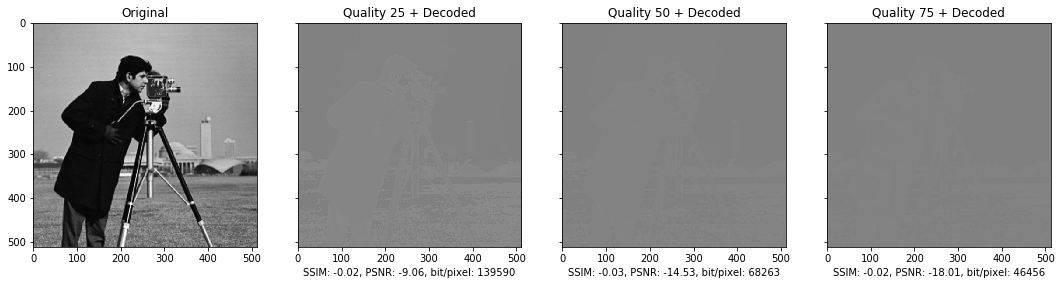

In [84]:
# Write your code here
import os

!python encoderquality.py 'cameraman.png' 'cameramanquality25.jpegenc' 25
!python encoderquality.py 'cameraman.png' 'cameramanquality50.jpegenc' 50
!python encoderquality.py 'cameraman.png' 'cameramanquality75.jpegenc' 75
!python decoder_pngoutput.py 'cameramanquality25.jpegenc' 'cameraman25'
!python decoder_pngoutput.py 'cameramanquality50.jpegenc' 'cameraman50'
!python decoder_pngoutput.py 'cameramanquality75.jpegenc' 'cameraman75'

img1 = cv.imread('cameraman.png', cv.IMREAD_COLOR)
img2 = cv.imread('cameraman25.png', cv.IMREAD_COLOR)
img3 = cv.imread('cameraman50.png', cv.IMREAD_COLOR)
img4 = cv.imread('cameraman75.png', cv.IMREAD_COLOR)

bytesize1 = os.path.getsize('cameraman.png')
bytesize2 = os.path.getsize('cameraman25.png')
bytesize3 = os.path.getsize('cameraman50.png')
bytesize4 = os.path.getsize('cameraman75.png')


img_original = img_as_float(img1)
img_transformed1 = img_as_float(img2)
img_transformed2 = img_as_float(img3)
img_transformed3 = img_as_float(img4)

psnr_metric1 = psnr(img_original, img_transformed1, data_range=img_transformed1.max() - img_transformed1.min())
ssim_metric1 = ssim(img_original, img_transformed1, data_range=img_transformed1.max() - img_transformed1.min(), multichannel=True)

psnr_metric2 = psnr(img_original, img_transformed2, data_range=img_transformed2.max() - img_transformed2.min())
ssim_metric2 = ssim(img_original, img_transformed2, data_range=img_transformed2.max() - img_transformed2.min(), multichannel=True)

psnr_metric3 = psnr(img_original, img_transformed3, data_range=img_transformed3.max() - img_transformed3.min())
ssim_metric3 = ssim(img_original, img_transformed3, data_range=img_transformed3.max() - img_transformed3.min(), multichannel=True)


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4), sharex=True, sharey=True)
ax = axes.ravel()
label = 'SSIM: %.2f, PSNR: %.2f, bit/pixel: %.0f'

ax[0].imshow(img_original)
ax[0].set_title('Original')

ax[1].imshow(img2)
ax[1].set_xlabel(label % (ssim_metric1, psnr_metric1, bytesize1))
ax[1].set_title('Quality 25 + Decoded')


ax[2].imshow(img3)
ax[2].set_xlabel(label % (ssim_metric2, psnr_metric2, bytesize2))
ax[2].set_title('Quality 50 + Decoded')


ax[3].imshow(img4)
ax[3].set_xlabel(label % (ssim_metric3, psnr_metric3, bytesize3))
ax[3].set_title('Quality 75 + Decoded')

plt.tight_layout()
plt.show()

### Exercise 4
* Implement a modified version of the JPEG encoder which allows for selecting the number of DCT-transformed coefficients to be used in the range [1, 64], without any quantization. 
* Plot the reconstructed image, the PSNR, the SSIM, and the bit/pixel values for a low, a medium and a high value of the number of DCT-transformed coefficients.
* Compare the results with those obtained in Exercise 3. You can try several images.

In [85]:
#@title encoderdct.py
%%writefile encoderdct.py
import argparse
import os
import math
import numpy as np
from utils import *
from scipy import fftpack
from PIL import Image
from huffman import HuffmanTree
from matplotlib.image import imread


def quantize(block, quality, component):
    q = load_quantization_table(component)
    np.multiply(q,quality, out=q, casting="unsafe")
    vectorize_round = np.vectorize(round)
    return (block / q).round().astype(np.int32)


def block_to_zigzag(block):
    return np.array([block[point] for point in zigzag_points(*block.shape)])


def dct_2d(image):
    return fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')


def run_length_encode(arr):
    # determine where the sequence is ending prematurely
    last_nonzero = -1
    for i, elem in enumerate(arr):
        if elem != 0:
            last_nonzero = i

    # each symbol is a (RUNLENGTH, SIZE) tuple
    symbols = []

    # values are binary representations of array elements using SIZE bits
    values = []

    run_length = 0

    for i, elem in enumerate(arr):
        if i > last_nonzero:
            symbols.append((0, 0))
            values.append(int_to_binstr(0))
            break
        elif elem == 0 and run_length < 15:
            run_length += 1
        else:
            size = bits_required(elem)
            symbols.append((run_length, size))
            values.append(int_to_binstr(elem))
            run_length = 0
    return symbols, values


def write_to_file(filepath, dc, ac, blocks_count, tables):
    try:
        f = open(filepath, 'w')
    except FileNotFoundError as e:
        raise FileNotFoundError(
                "No such directory: {}".format(
                    os.path.dirname(filepath))) from e

    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:

        # 16 bits for 'table_size'
        f.write(uint_to_binstr(len(tables[table_name]), 16))

        for key, value in tables[table_name].items():
            if table_name in {'dc_y', 'dc_c'}:
                # 4 bits for the 'category'
                # 4 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key, 4))
                f.write(uint_to_binstr(len(value), 4))
                f.write(value)
            else:
                # 4 bits for 'run_length'
                # 4 bits for 'size'
                # 8 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key[0], 4))
                f.write(uint_to_binstr(key[1], 4))
                f.write(uint_to_binstr(len(value), 8))
                f.write(value)

    # 32 bits for 'blocks_count'
    f.write(uint_to_binstr(blocks_count, 32))

    for b in range(blocks_count):
        for c in range(3):
            category = bits_required(dc[b, c])
            symbols, values = run_length_encode(ac[b, :, c])

            dc_table = tables['dc_y'] if c == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if c == 0 else tables['ac_c']

            f.write(dc_table[category])
            f.write(int_to_binstr(dc[b, c]))

            for i in range(len(symbols)):
                f.write(ac_table[tuple(symbols[i])])
                f.write(values[i])
    f.close()



def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("input", help="path to the input image")
    parser.add_argument("output", help="path to the output image")
    parser.add_argument("dct", help="DCT-transformed coefficients to be used in the range [1, 64]")
    args = parser.parse_args()

    input_file = args.input
    output_file = args.output
    dct_coefficients = int(args.dct)

    image = Image.open(input_file)
    ycbcr = image.convert('YCbCr')

    npmat = np.array(ycbcr, dtype=np.uint8)

    rows, cols = npmat.shape[0], npmat.shape[1]

    dct_coefficients_sqrd = int(np.round(math.sqrt(dct_coefficients))) 


    # block size: 8x8
    if rows % 8 == cols % 8 == 0:
        blocks_count = rows // dct_coefficients_sqrd * cols // dct_coefficients_sqrd
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of 8"))
    # dc is the top-left cell of the block, ac are all the other cells
    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, dct_coefficients - 1, 3), dtype=np.int32)
    
    for i in range(0, rows, dct_coefficients_sqrd):
        for j in range(0, cols, dct_coefficients_sqrd):
            try:
                block_index += 1
            except NameError:
                block_index = 0

            for k in range(3):
                # split 8x8 block and center the data range on zero
                # [0, 255] --> [-128, 127]
                block = npmat[i:i+dct_coefficients_sqrd, j:j+dct_coefficients_sqrd, k] - 128

                dct_matrix = dct_2d(block)
                #quant_matrix = quantize(dct_matrix, quality, 'lum' if k == 0 else 'chrom')
                zz = block_to_zigzag(dct_matrix)

                dc[block_index, k] = zz[0]
                ac[block_index, :, k] = zz[1:]

    H_DC_Y = HuffmanTree(np.vectorize(bits_required)(dc[:, 0]))
    H_DC_C = HuffmanTree(np.vectorize(bits_required)(dc[:, 1:].flat))
    H_AC_Y = HuffmanTree(
            flatten(run_length_encode(ac[i, :, 0])[0]
                    for i in range(blocks_count)))
    H_AC_C = HuffmanTree(
            flatten(run_length_encode(ac[i, :, j])[0]
                    for i in range(blocks_count) for j in [1, 2]))

    tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
              'ac_y': H_AC_Y.value_to_bitstring_table(),
              'dc_c': H_DC_C.value_to_bitstring_table(),
              'ac_c': H_AC_C.value_to_bitstring_table()}

    write_to_file(output_file, dc, ac, blocks_count, tables)

if __name__ == "__main__":
    main()



Overwriting encoderdct.py


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30:

Text(0.5, 1.0, 'DCT 64 + Decoded')

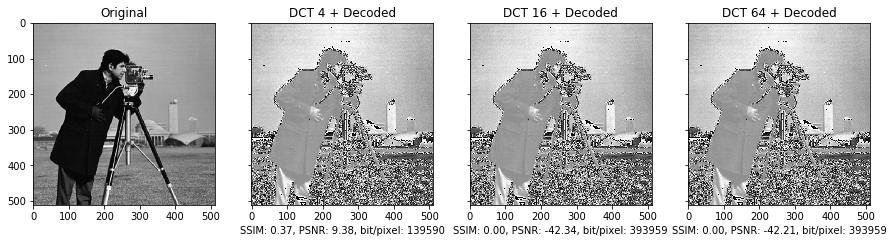

In [95]:
# Write your code here
!python encoderdct.py 'cameraman.png' 'cameramandct1.jpegenc' 64
!python encoderdct.py 'cameraman.png' 'cameramandct2.jpegenc' 64
!python encoderdct.py 'cameraman.png' 'cameramandct3.jpegenc' 64
!python decoder_pngoutput.py 'cameramandct1.jpegenc' 'cameramandct1'
!python decoder_pngoutput.py 'cameramandct2.jpegenc' 'cameramandct2'
!python decoder_pngoutput.py 'cameramandct3.jpegenc' 'cameramandct3'


img1 = cv.imread('cameraman.png', cv.IMREAD_COLOR)
imgdct2 = cv.imread('cameramandct1.png', cv.IMREAD_COLOR)
imgdct3 = cv.imread('cameramandct2.png', cv.IMREAD_COLOR)
imgdct4 = cv.imread('cameramandct3.png', cv.IMREAD_COLOR)

bytesize1 = os.path.getsize('cameraman.png')
bytesize2 = os.path.getsize('cameramandct1.png')
bytesize3 = os.path.getsize('cameramandct2.png')
bytesize4 = os.path.getsize('cameramandct3.png')

img_original = img_as_float(img1)
img_transformed1 = img_as_float(imgdct2)
img_transformed2 = img_as_float(imgdct3)
img_transformed3 = img_as_float(imgdct4)

psnr_metric1 = psnr(img_original, img_transformed1, data_range=img_transformed1.max() - img_transformed1.min())
ssim_metric1 = ssim(img_original, img_transformed1, data_range=img_transformed1.max() - img_transformed1.min(), multichannel=True)

psnr_metric2 = psnr(img_original, img_transformed2, data_range=img_transformed2.max() - img_transformed2.min())
ssim_metric2 = ssim(img_original, img_transformed2, data_range=img_transformed2.max() - img_transformed2.min(), multichannel=True)

psnr_metric3 = psnr(img_original, img_transformed3, data_range=img_transformed3.max() - img_transformed3.min())
ssim_metric3 = ssim(img_original, img_transformed3, data_range=img_transformed3.max() - img_transformed3.min(), multichannel=True)


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4), sharex=True, sharey=True)
ax = axes.ravel()
label = 'SSIM: %.2f, PSNR: %.2f, bit/pixel: %.0f'

ax[0].imshow(img_original)
ax[0].set_title('Original')

ax[1].imshow(img_transformed1)
ax[1].set_xlabel(label % (ssim_metric1, psnr_metric1, bytesize1))
ax[1].set_title('DCT 4 + Decoded')


ax[2].imshow(img_transformed2)
ax[2].set_xlabel(label % (ssim_metric2, psnr_metric2, bytesize2))
ax[2].set_title('DCT 16 + Decoded')


ax[3].imshow(img_transformed3)
ax[3].set_xlabel(label % (ssim_metric3, psnr_metric3, bytesize3))
ax[3].set_title('DCT 64 + Decoded')


### Exercise 5: Lossless JPEG
* Implement a lossless JPEG coder consisting only in skipping the quantization step both at the encoder and decoder. 
* Plot the reconstructed image, the PSNR, the SSIM, and the bit/pixel values. 
* Is it better than compressing the image directly with a binary compression tool such as zip, 7zip, gzip, etc.? Explain why.
* Propose (it is not required to be implemented) a better strategy to implement a lossless JPEG coder considering the original implementation in `encoder.py`.

It is in fact worse than compressing the image directly with a binary compression tool because of the conversion process from PNG to YCrCb. Additionaly, zip compression is optimized for any type of file.  

Efficiently, calculating all blocks and each DCT is time costly compared with ZIP compression.

Exercise 4 already skips the quantization step. We only need the decoder implementation.

In [89]:
#@title loslessdecoder.py
%%writefile loslessdecoder.py
import argparse
import math
import numpy as np
from utils import *
from scipy import fftpack
from PIL import Image


class JPEGFileReader:
    TABLE_SIZE_BITS = 16
    BLOCKS_COUNT_BITS = 32

    DC_CODE_LENGTH_BITS = 4
    CATEGORY_BITS = 4

    AC_CODE_LENGTH_BITS = 8
    RUN_LENGTH_BITS = 4
    SIZE_BITS = 4

    def __init__(self, filepath):
        self.__file = open(filepath, 'r')

    def read_int(self, size):
        if size == 0:
            return 0

        # the most significant bit indicates the sign of the number
        bin_num = self.__read_str(size)
        if bin_num[0] == '1':
            return self.__int2(bin_num)
        else:
            return self.__int2(binstr_flip(bin_num)) * -1

    def read_dc_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            category = self.__read_uint(self.CATEGORY_BITS)
            code_length = self.__read_uint(self.DC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = category
        return table

    def read_ac_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            run_length = self.__read_uint(self.RUN_LENGTH_BITS)
            size = self.__read_uint(self.SIZE_BITS)
            code_length = self.__read_uint(self.AC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = (run_length, size)
        return table

    def read_blocks_count(self):
        return self.__read_uint(self.BLOCKS_COUNT_BITS)

    def read_huffman_code(self, table):
        prefix = ''
        # TODO: break the loop if __read_char is not returing new char
        while prefix not in table:
            prefix += self.__read_char()
        return table[prefix]

    def __read_uint(self, size):
        if size <= 0:
            raise ValueError("size of unsigned int should be greater than 0")
        return self.__int2(self.__read_str(size))

    def __read_str(self, length):
        return self.__file.read(length)

    def __read_char(self):
        return self.__read_str(1)

    def __int2(self, bin_num):
        return int(bin_num, 2)


def read_image_file(filepath):
    reader = JPEGFileReader(filepath)

    tables = dict()
    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:
        if 'dc' in table_name:
            tables[table_name] = reader.read_dc_table()
        else:
            tables[table_name] = reader.read_ac_table()

    blocks_count = reader.read_blocks_count()

    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for block_index in range(blocks_count):
        for component in range(3):
            dc_table = tables['dc_y'] if component == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if component == 0 else tables['ac_c']

            category = reader.read_huffman_code(dc_table)
            dc[block_index, component] = reader.read_int(category)

            cells_count = 0

            # TODO: try to make reading AC coefficients better
            while cells_count < 63:
                run_length, size = reader.read_huffman_code(ac_table)

                if (run_length, size) == (0, 0):
                    while cells_count < 63:
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                else:
                    for i in range(run_length):
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                    if size == 0:
                        ac[block_index, cells_count, component] = 0
                    else:
                        value = reader.read_int(size)
                        ac[block_index, cells_count, component] = value
                    cells_count += 1

    return dc, ac, tables, blocks_count


def zigzag_to_block(zigzag):
    # assuming that the width and the height of the block are equal
    rows = cols = int(math.sqrt(len(zigzag)))

    if rows * cols != len(zigzag):
        raise ValueError("length of zigzag should be a perfect square")

    block = np.empty((rows, cols), np.int32)

    for i, point in enumerate(zigzag_points(rows, cols)):
        block[point] = zigzag[i]

    return block


def dequantize(block, component):
    q = load_quantization_table(component)
    return block * q


def idct_2d(image):
    return fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("input", help="path to the input image")
    parser.add_argument("output", help="path to the output image")
    args = parser.parse_args()

    dc, ac, tables, blocks_count = read_image_file(args.input)
    output_file = args.output

    # assuming that the block is a 8x8 square
    block_side = 8

    # assuming that the image height and width are equal
    image_side = int(math.sqrt(blocks_count)) * block_side

    blocks_per_line = image_side // block_side

    npmat = np.empty((image_side, image_side, 3), dtype=np.uint8)

    for block_index in range(blocks_count):
        i = block_index // blocks_per_line * block_side
        j = block_index % blocks_per_line * block_side

        for c in range(3):
            zigzag = [dc[block_index, c]] + list(ac[block_index, :, c])
            quant_matrix = zigzag_to_block(zigzag)
            #dct_matrix = dequantize(quant_matrix, 'lum' if c == 0 else 'chrom')
            block = idct_2d(quant_matrix)
            npmat[i:i+8, j:j+8, c] = block + 128

    image = Image.fromarray(npmat, 'YCbCr')
    image = image.convert('RGB')
    image.save(output_file+'.png', optimize=True, compress_level = 0)


if __name__ == "__main__":
    main()


Overwriting loslessdecoder.py


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Loseless + Decoded')

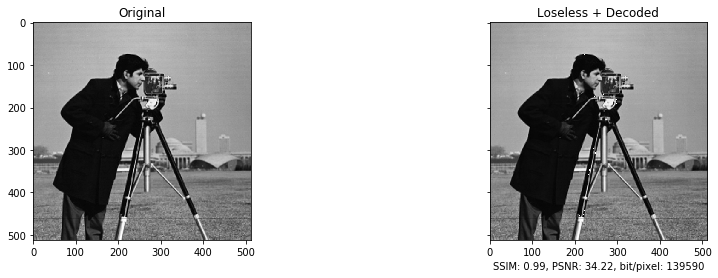

In [90]:
# Write your code here
!python encoderdct.py 'cameraman.png' 'cameramanloseless.jpegenc' 64
!python loslessdecoder.py 'cameramanloseless.jpegenc' 'cameramanloseless'


img1 = cv.imread('cameraman.png', cv.IMREAD_COLOR)
cameramanloseless = cv.imread('cameramanloseless.png', cv.IMREAD_COLOR)

bytesize1 = os.path.getsize('cameraman.png')
bytesize2 = os.path.getsize('cameramanloseless.png')

img_original = img_as_float(img1)
img_transformed1 = img_as_float(cameramanloseless)

psnr_metric1 = psnr(img_original, img_transformed1, data_range=img_transformed1.max() - img_transformed1.min())
ssim_metric1 = ssim(img_original, img_transformed1, data_range=img_transformed1.max() - img_transformed1.min(), multichannel=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4), sharex=True, sharey=True)
ax = axes.ravel()
label = 'SSIM: %.2f, PSNR: %.2f, bit/pixel: %.0f'

ax[0].imshow(img_original)
ax[0].set_title('Original')

ax[1].imshow(img_transformed1)
ax[1].set_xlabel(label % (ssim_metric1, psnr_metric1, bytesize1))
ax[1].set_title('Loseless + Decoded')
